## 6233 Андреев АЮ ЛР 1 Персептрон

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier

# настройка графиков
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

#### 0. Выбрать любой подходящий датасет для классификации, например digits dataset из sklearn или MNIST из keras.

In [4]:
# Обычный датасет с цитфрами, формата 8 на 8 с одним каналом цвета
from sklearn.datasets import load_digits 
digits = load_digits()
# разделяем данные на тренировочные и тестовый
x_train, x_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.2, shuffle=True, random_state=42)

#### 1. Реализовать однослойный перцептрон без использования библиотек
* Выбрать функцию активации, например, сигмоиду.
* Реализовать прямой проход.
* Вычислить ошибку.
* Реализовать обратный проход, скорректировать веса НС.
* Реализовать функцию обучения НС с параметром количества эпох (итераций).

In [5]:
class Perseptron:
    
    def __init__(self):
        self.W = None
# функция вычисления ошибки
    def loss(self, W, X, y, reg):

        loss = 0.0
        dW = np.zeros(W.shape) 
# умножаем на веса
        scores = X.dot(W)
# определяем правильные метки классов
        correct_label_score_idxes = (range(scores.shape[0]), y)
# оставляем значения, где мы ошибились
        correct_label_scores = scores[correct_label_score_idxes]
# вычисляем насколько ошибились
        scores_diff = scores - np.reshape(correct_label_scores, (-1, 1)) + 1
# в правильных классах ошибку ставим равную нулю
        scores_diff[correct_label_score_idxes] = 0
# ReLU
        scores_diff[np.nonzero(scores_diff < 0)] = 0
# суммируем ошибку
        loss = scores_diff.sum()
        num_train = X.shape[0]
# нормируем и не забываем про коэфф регуляризации        
        loss /= num_train
        loss += 0.5 * reg * np.sum(W * W)
# корректируем правильные метки классов
        scores_diff[scores_diff > 0] = 1
        correct_label_vals = -1 * scores_diff.sum(axis=1)
        scores_diff[correct_label_score_idxes] = correct_label_vals
# высчитываем градиент
        dW = X.T.dot(scores_diff)
        dW /= num_train
        dW += reg * W

        return loss, dW

    def train(self, X, y, learning_rate=1e-3, reg=1e-5, num_iters=100,
              batch_size=200, verbose=False):
        
        
        num_train, dim = X.shape
        num_classes = np.max(y) + 1
        iterations_per_epoch = max(num_train // batch_size, 1)
# рандомно заполняем веса        
        if self.W is None:
            self.W = 0.001 * np.random.randn(dim, num_classes)
        
        loss_history = []
        train_acc_history = []
        
        for it in range(num_iters):
            X_batch = None
            y_batch = None

# делим данные на батчи
            batch_idxes = np.random.choice(num_train, batch_size, replace=True)
            X_batch = X[batch_idxes, :]
            y_batch = y[batch_idxes]
# высчитываем ошибку и градиентт
            loss, grad = self.loss(self.W, X_batch, y_batch, reg)
            
            loss_history.append(loss)
            
# пересчитываем веса через антиградиент
            self.W -= learning_rate * grad

# вывод метрики каждые 100 итераций
            if verbose and it % 100 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))
                
            if it % iterations_per_epoch == 0:
                train_acc = (self.predict(X_batch) == y_batch).mean()
                train_acc_history.append(train_acc)

        return train_acc_history, loss_history
    
    def predict(self, X):
       
        y_pred = np.zeros(X.shape[0])
# простое предсказание через матричное умножение и аргмакс
        class_preds = X.dot(self.W)
        y_pred = class_preds.argmax(axis=1)
        
        return y_pred

#### Вывести метрики

In [6]:
persep = Perseptron()

train_acc_history, loss_history = persep.train(x_train, y_train, learning_rate=1e-3, reg=1e-2,
                                               num_iters=1500, verbose=True)

y_train_pred = persep.predict(x_train)
print(f'Training accuracy: {np.mean(y_train == y_train_pred)}')

y_test_pred = persep.predict(x_test)
print(f'Test accuracy: %f' % (np.mean(y_test == y_test_pred), ))

iteration 0 / 1500: loss 9.032633
iteration 100 / 1500: loss 0.196764
iteration 200 / 1500: loss 0.161351
iteration 300 / 1500: loss 0.144538
iteration 400 / 1500: loss 0.075492
iteration 500 / 1500: loss 0.085148
iteration 600 / 1500: loss 0.032779
iteration 700 / 1500: loss 0.107681
iteration 800 / 1500: loss 0.083237
iteration 900 / 1500: loss 0.045608
iteration 1000 / 1500: loss 0.051646
iteration 1100 / 1500: loss 0.113237
iteration 1200 / 1500: loss 0.024876
iteration 1300 / 1500: loss 0.073096
iteration 1400 / 1500: loss 0.036086
Training accuracy: 0.9895615866388309
Test accuracy: 0.972222


#### Построить сопутствующие графики.

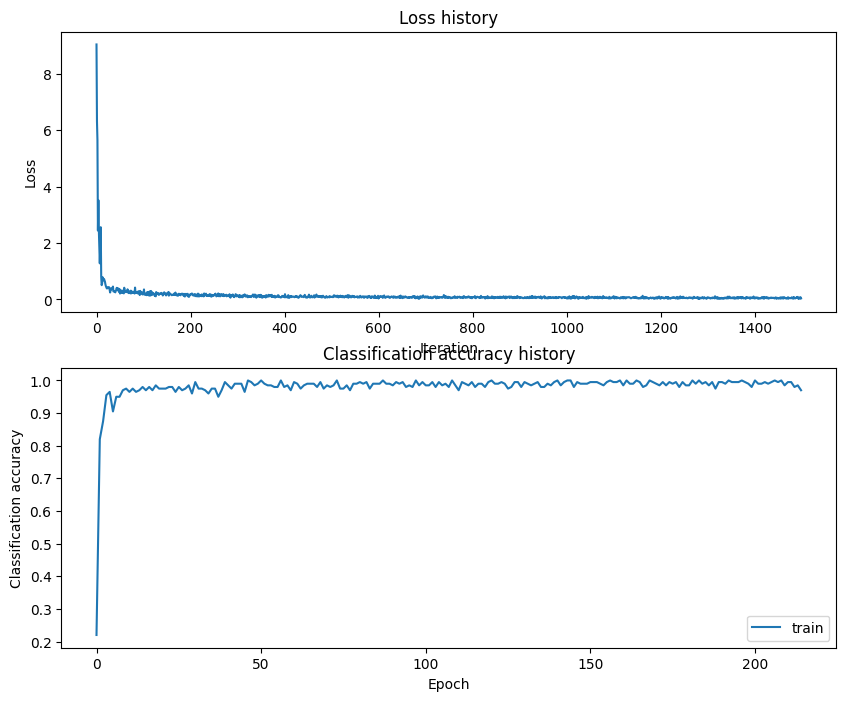

In [7]:
plt.subplot(2, 1, 1)
plt.plot(loss_history)
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(train_acc_history, label='train')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend()
plt.show()

#### 2. Сравнить результаты с использованием однослойного перцептрона из sklearn.

In [8]:
clf = Perceptron(alpha = 1e-2)
clf.fit(x_train, y_train)

y_test_pred = clf.predict(x_test)
print(f'Test accuracy: %f' % (np.mean(y_test == y_test_pred), ))

Test accuracy: 0.952778


#### 3. Сравнить результаты с использованием многослойного перцептрона из sklearn.

In [9]:
clf = MLPClassifier(random_state=1, max_iter=300)
clf.fit(x_train, y_train)

y_test_pred = clf.predict(x_test)
print(f'Test accuracy: %f' % (np.mean(y_test == y_test_pred), ))

Test accuracy: 0.980556
